In [1]:
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
sampling_methods = ['random', 'uncertainty', "BGADL", "OpenMax", "Core_set", 'certainty']
datasets = {'Tiny-Imagenet': {'init_percent': 8, 'known_class': [40, 60, 80]},
            'cifar100': {'init_percent': 8, 'known_class': [20, 30, 40]},
            'cifar10': {'init_percent': 1, 'known_class': [2, 3, 4]}}

In [3]:
def load_pkl_files(dataset_name, known_class):
    pkl_files = []
    log_al_folder = 'log_AL/'
    for file in os.listdir(log_al_folder):
        if file.endswith('.pkl') and f"{dataset_name}_" in file and f"known{known_class}" in file:
            pkl_files.append(os.path.join(log_al_folder, file))
    return pkl_files

In [4]:
def plot_graphs(group_name, acc_list, precision_list, recall_list):
    query_numbers = list(range(len(acc_list[0])))

    plt.figure()
    for acc in acc_list:
        plt.plot(query_numbers, acc)
    plt.xlabel('Query Numbers')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {group_name}')
    plt.legend(sampling_methods)
    plt.show()

    plt.figure()
    for precision in precision_list:
        plt.plot(query_numbers, precision)
    plt.xlabel('Query Numbers')
    plt.ylabel('Precision')
    plt.title(f'Precision for {group_name}')
    plt.legend(sampling_methods)
    plt.show()

    plt.figure()
    for recall in recall_list:
        plt.plot(query_numbers, recall)
    plt.xlabel('Query Numbers')
    plt.ylabel('Recall')
    plt.title(f'Recall for {group_name}')
    plt.legend(sampling_methods)
    plt.show()

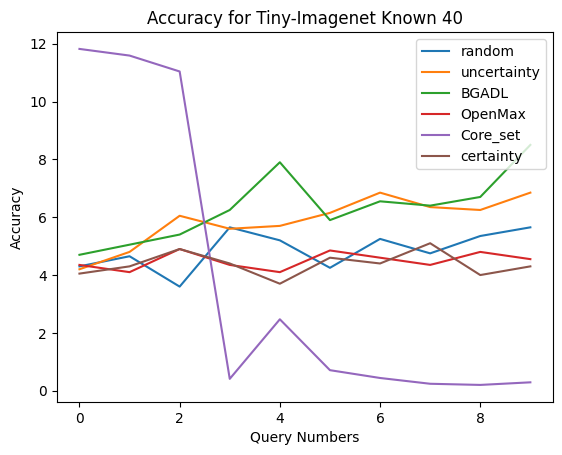

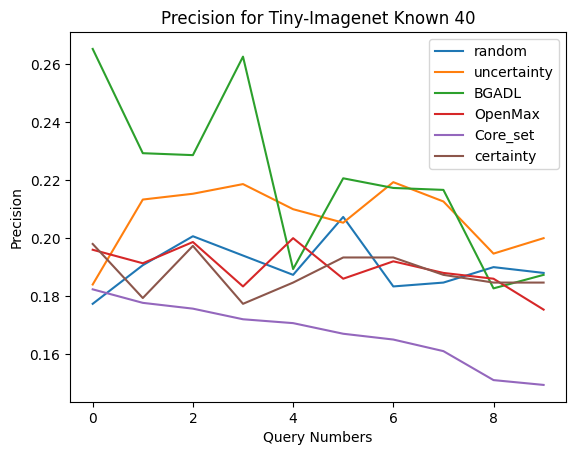

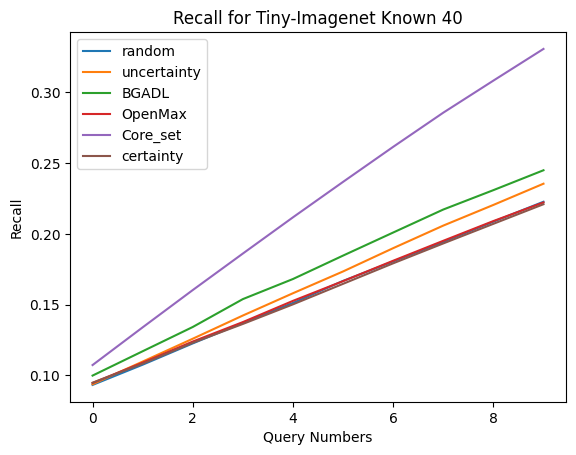

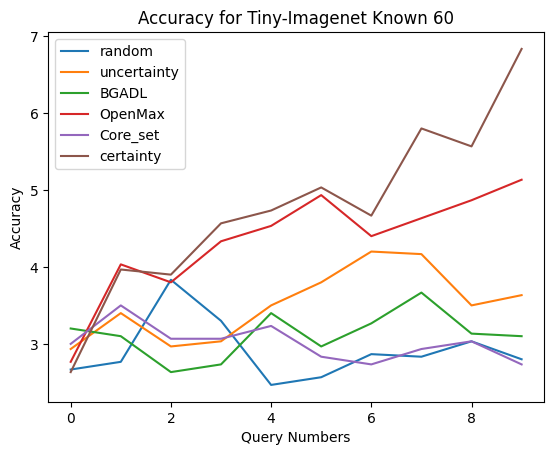

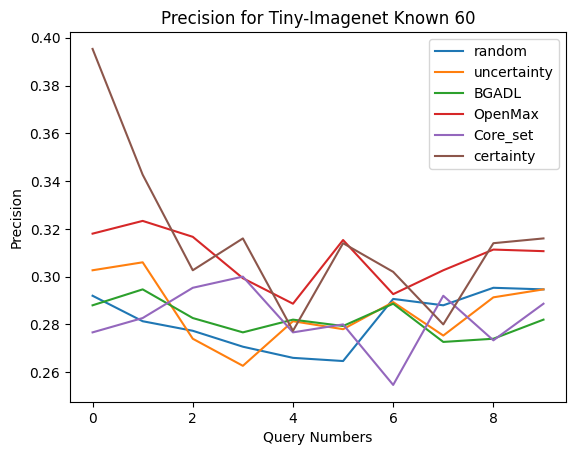

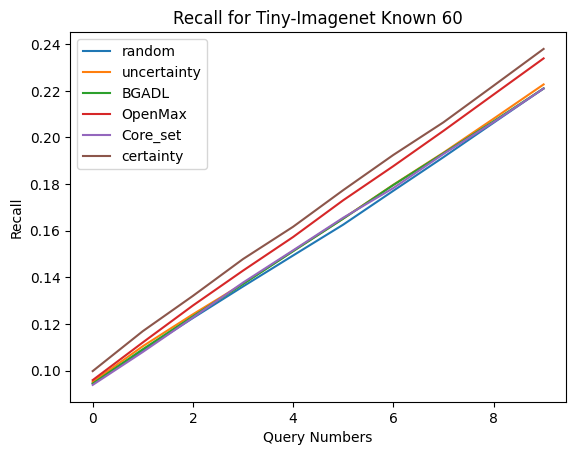

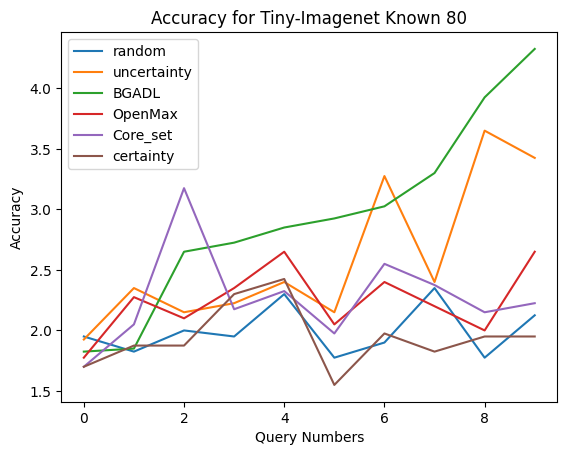

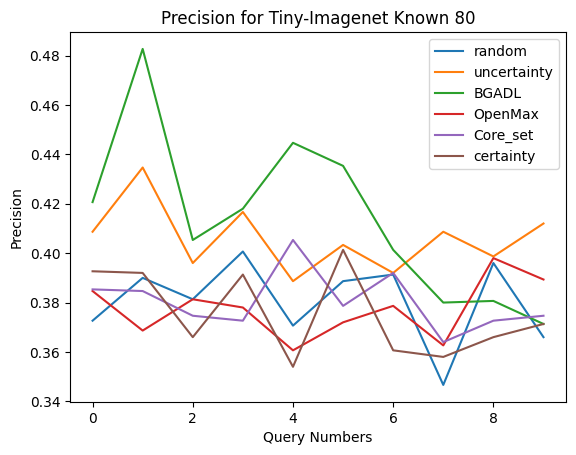

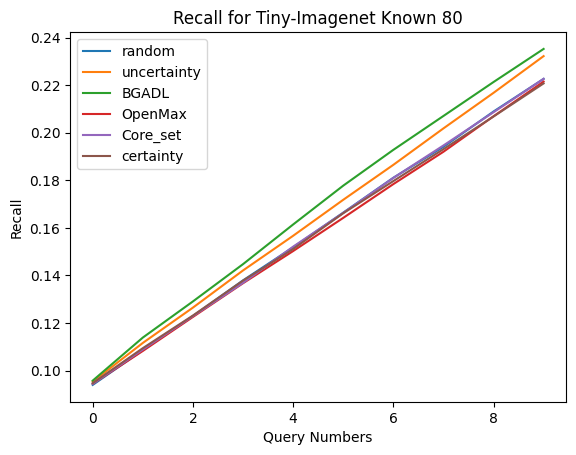

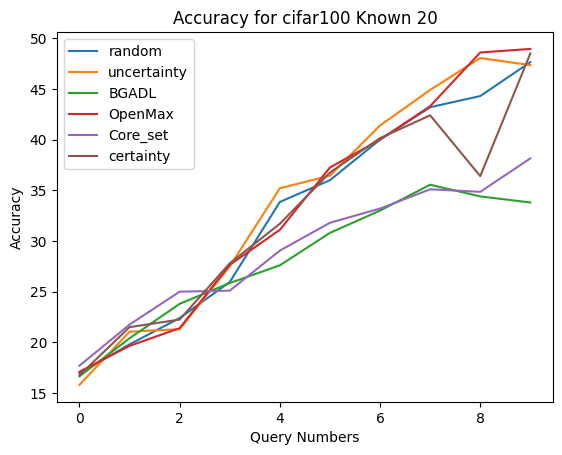

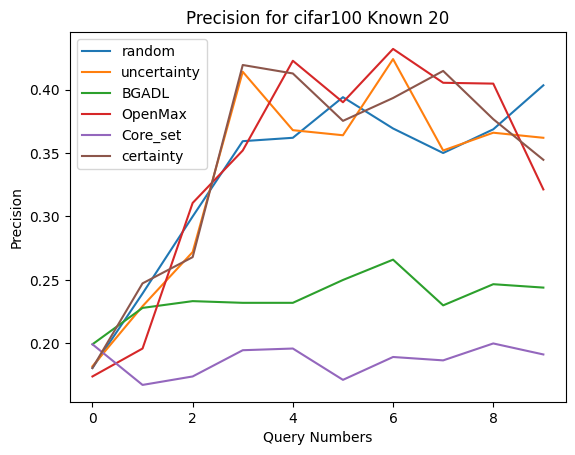

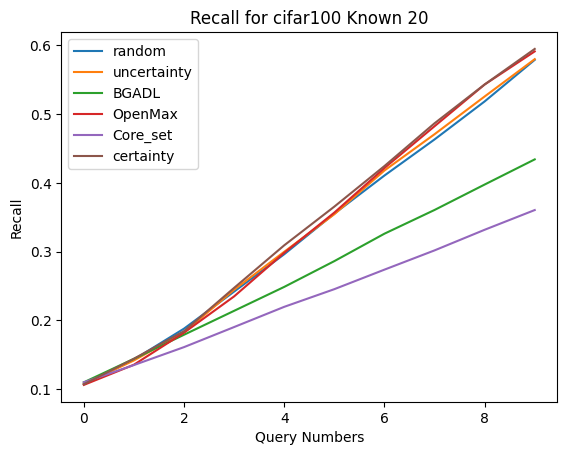

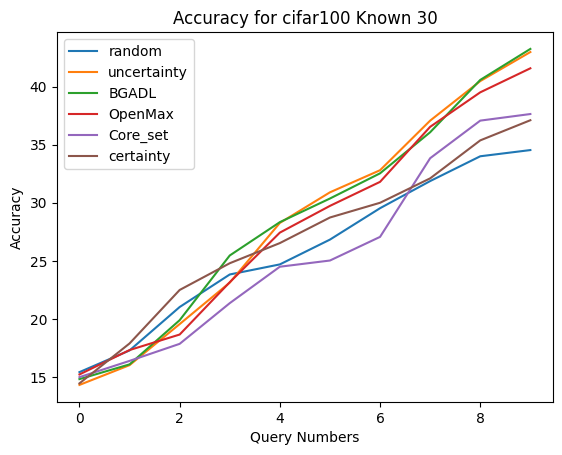

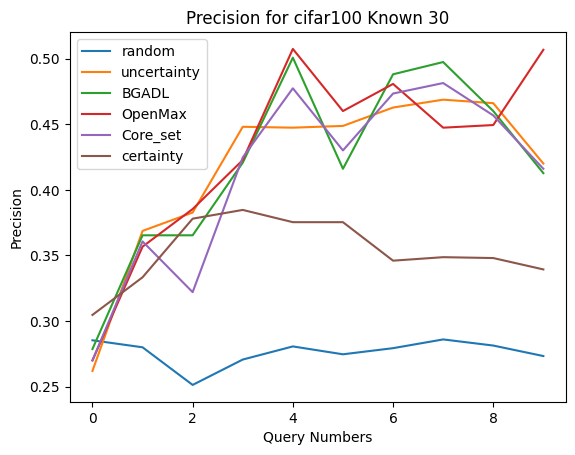

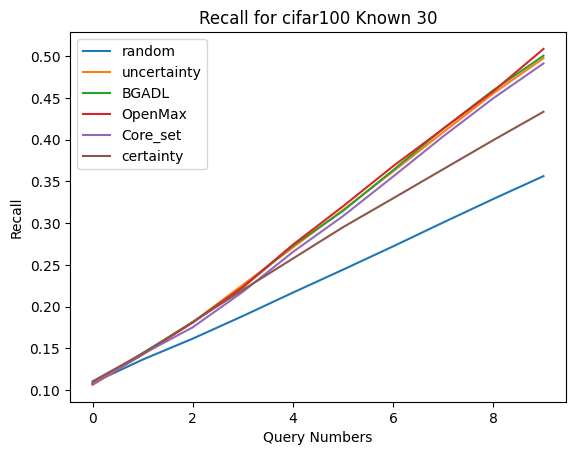

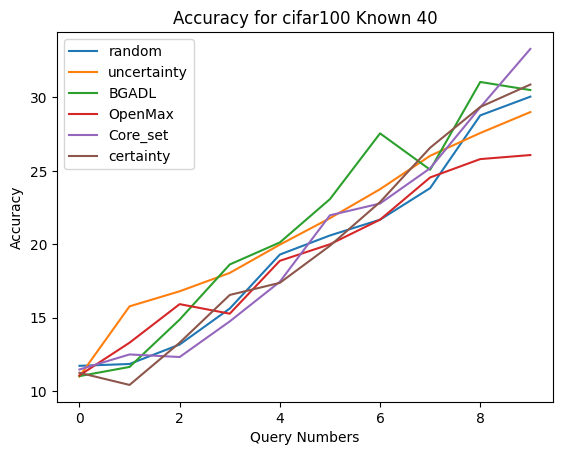

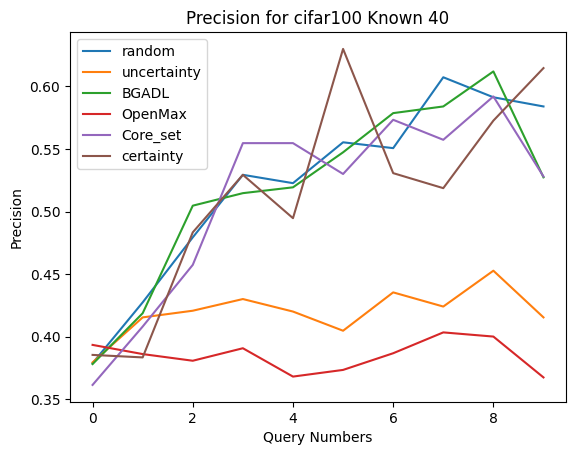

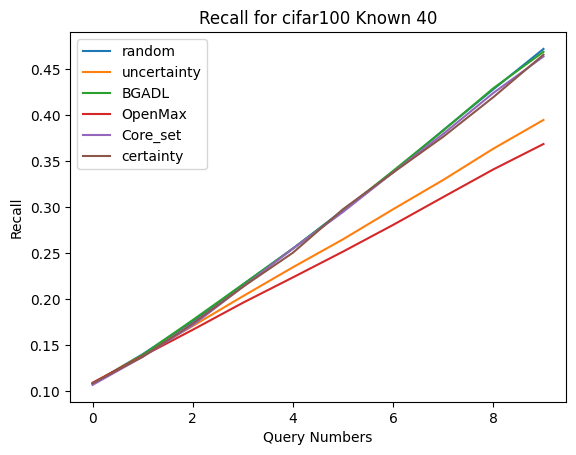

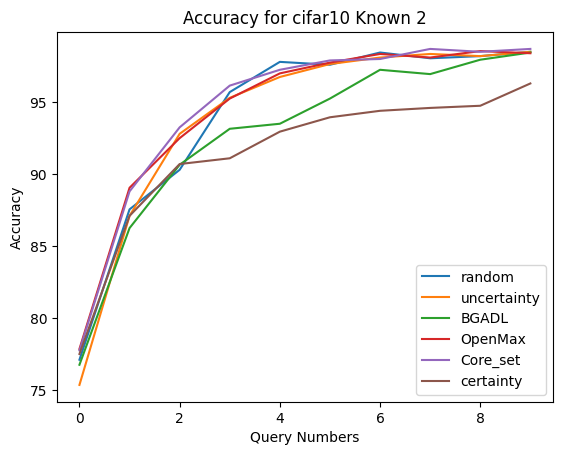

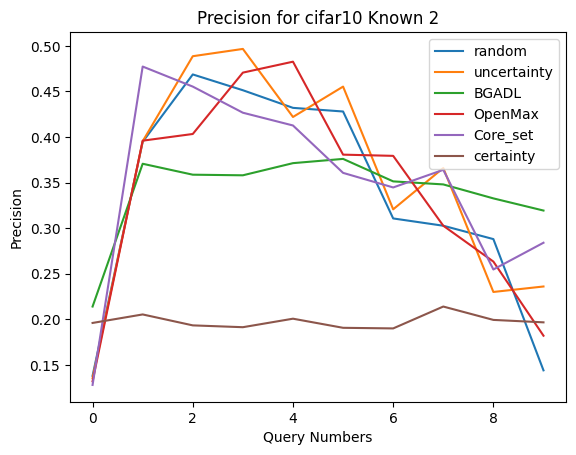

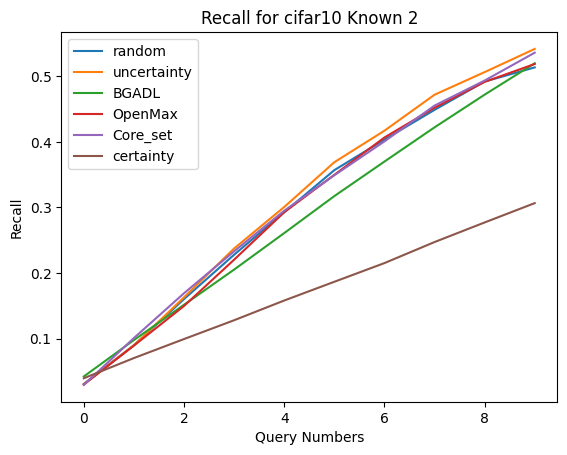

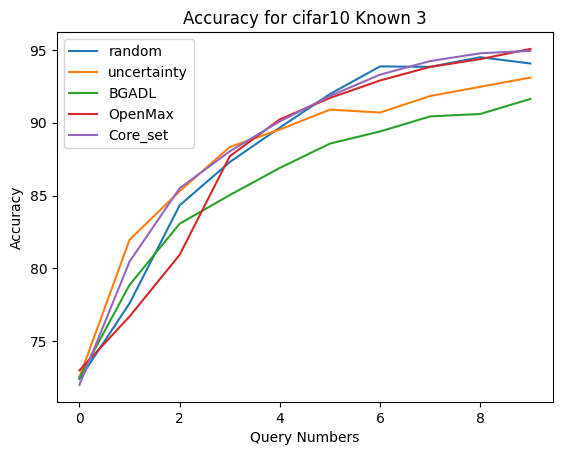

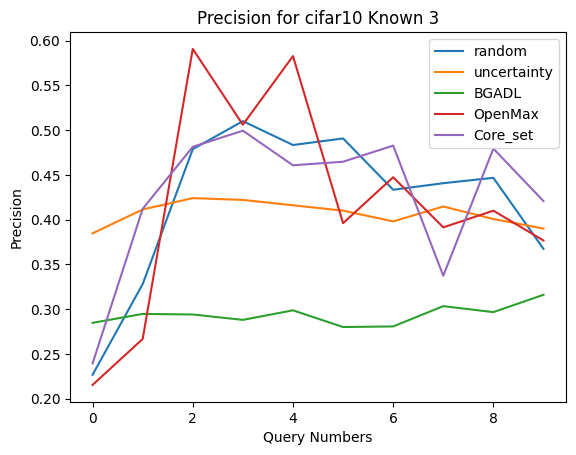

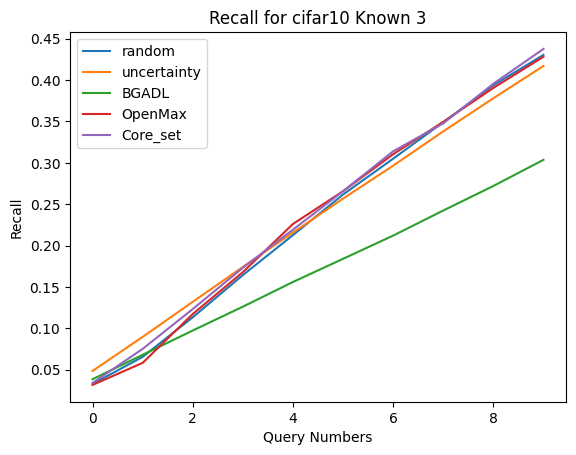

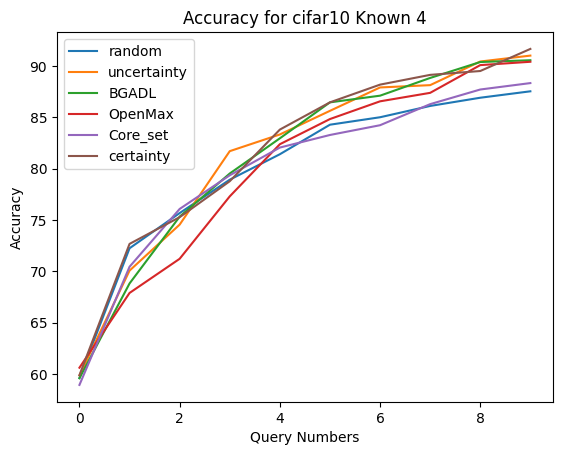

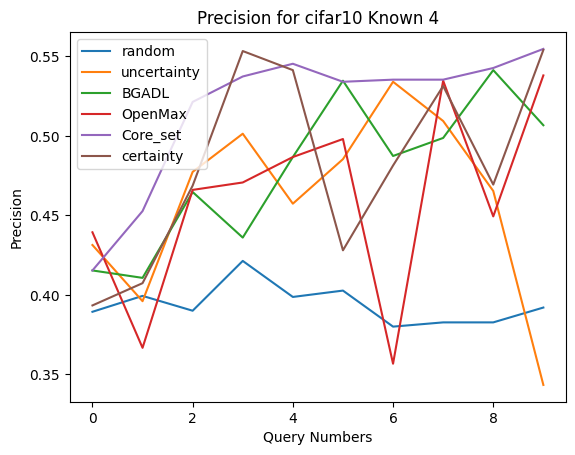

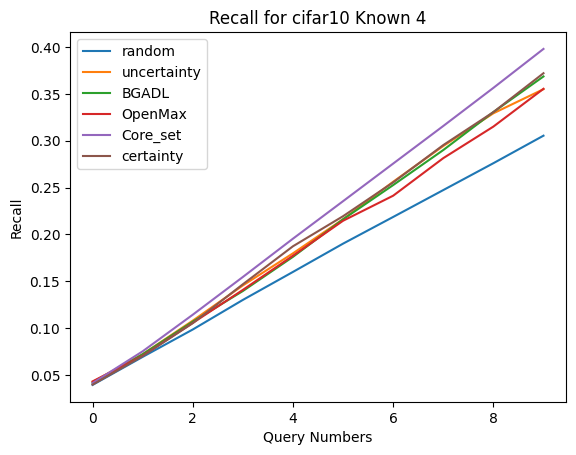

In [5]:
for dataset_name, dataset_info in datasets.items():
    for known_class in dataset_info['known_class']:
        group_name = f"{dataset_name} Known {known_class}"
        pkl_files = load_pkl_files(dataset_name, known_class)
        acc_list, precision_list, recall_list = [], [], []

        for file in pkl_files:
            with open(file, 'rb') as f:
                data = pickle.load(f)
                acc_list.append([data['Acc'][i] for i in data['Acc']])
                precision_list.append([data['Precision'][i] for i in data['Precision']])
                recall_list.append([data['Recall'][i] for i in data['Recall']])

        plot_graphs(group_name, acc_list, precision_list, recall_list)